In [1]:
%run init_notebook.py

Module aliases imported by init_notebook.py:
--------------------------------------------
import numpy as np

import pandas as pd

from scipy import stats as stats

from matplotlib import pyplot as plt

import statsmodels.formula.api as smf

Watermark:
----------
Last updated: 2023-10-13T10:57:55.923752-07:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.16.1

Compiler    : Clang 15.0.7 
OS          : Darwin
Release     : 22.2.0
Machine     : arm64
Processor   : arm
CPU cores   : 10
Architecture: 64bit

statsmodels: 0.14.0
numpy      : 1.26.0
scipy      : 1.11.3
pandas     : 2.1.1
matplotlib : 3.8.0



<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#AB-Testing-Experiments-as-Statistical-inference" data-toc-modified-id="AB-Testing-Experiments-as-Statistical-inference-0.1">AB Testing Experiments as Statistical inference</a></span></li><li><span><a href="#What-exactly-do-we-mean-by-&quot;difference-between-groups&quot;?" data-toc-modified-id="What-exactly-do-we-mean-by-&quot;difference-between-groups&quot;?-0.2">What exactly do we mean by "difference between groups"?</a></span></li><li><span><a href="#Hypothesis-Tests" data-toc-modified-id="Hypothesis-Tests-0.3">Hypothesis Tests</a></span><ul class="toc-item"><li><span><a href="#Quantifying-comparison-valence" data-toc-modified-id="Quantifying-comparison-valence-0.3.1">Quantifying comparison <em>valence</em></a></span></li><li><span><a href="#Quantifying-comparison-magnitude:-effect-size" data-toc-modified-id="Quantifying-comparison-magnitude:-effect-size-0.3.2">Quantifying comparison magnitude: effect size</a></span></li><li><span><a href="#Quantifying-the-reliability-of-differences" data-toc-modified-id="Quantifying-the-reliability-of-differences-0.3.3">Quantifying the reliability of differences</a></span></li><li><span><a href="#Quantifying-magnitude-and-effect-size" data-toc-modified-id="Quantifying-magnitude-and-effect-size-0.3.4">Quantifying magnitude and effect size</a></span></li></ul></li></ul></li><li><span><a href="#Inferential-Statistics" data-toc-modified-id="Inferential-Statistics-1">Inferential Statistics</a></span></li><li><span><a href="#Central-Limit-Theorem,-Standard-Errors,-and-Confidence-Intervals" data-toc-modified-id="Central-Limit-Theorem,-Standard-Errors,-and-Confidence-Intervals-2">Central Limit Theorem, Standard Errors, and Confidence Intervals</a></span><ul class="toc-item"><li><span><a href="#Standard-Error-of-the-Mean" data-toc-modified-id="Standard-Error-of-the-Mean-2.1">Standard Error of the Mean</a></span></li><li><span><a href="#Pooled-Standard-Error" data-toc-modified-id="Pooled-Standard-Error-2.2">Pooled Standard Error</a></span></li><li><span><a href="#Type-I--Error-($\alpha$),-Type-II-Error-($\beta$),-and-Inferential-Power" data-toc-modified-id="Type-I--Error-($\alpha$),-Type-II-Error-($\beta$),-and-Inferential-Power-2.3">Type I  Error ($\alpha$), Type II Error ($\beta$), and Inferential Power</a></span><ul class="toc-item"><li><span><a href="#Type-I-and-Type-II-Errors" data-toc-modified-id="Type-I-and-Type-II-Errors-2.3.1">Type I and Type II Errors</a></span></li></ul></li><li><span><a href="#Power" data-toc-modified-id="Power-2.4">Power</a></span><ul class="toc-item"><li><span><a href="#Power-vs-effect-size" data-toc-modified-id="Power-vs-effect-size-2.4.1">Power vs effect size</a></span></li><li><span><a href="#Power-vs-distribution-variance" data-toc-modified-id="Power-vs-distribution-variance-2.4.2">Power vs distribution variance</a></span></li><li><span><a href="#Power-vs-$\alpha$" data-toc-modified-id="Power-vs-$\alpha$-2.4.3">Power vs $\alpha$</a></span></li><li><span><a href="#Power-vs-Sample-Size" data-toc-modified-id="Power-vs-Sample-Size-2.4.4">Power vs Sample Size</a></span></li></ul></li></ul></li><li><span><a href="#Frequentist-Approach-to-Inference" data-toc-modified-id="Frequentist-Approach-to-Inference-3">Frequentist Approach to Inference</a></span><ul class="toc-item"><li><span><a href="#Frequentist-Testing-Gotcha" data-toc-modified-id="Frequentist-Testing-Gotcha-3.1">Frequentist Testing Gotcha</a></span><ul class="toc-item"><li><span><a href="#Data-Peeking" data-toc-modified-id="Data-Peeking-3.1.1">Data Peeking</a></span></li><li><span><a href="#p-hacking" data-toc-modified-id="p-hacking-3.1.2">p-hacking</a></span><ul class="toc-item"><li><span><a href="#p-hacking-by-Adding-Additional-Samples" data-toc-modified-id="p-hacking-by-Adding-Additional-Samples-3.1.2.1">p-hacking by Adding Additional Samples</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Bayesian-Approach-to-Inference" data-toc-modified-id="Bayesian-Approach-to-Inference-4">Bayesian Approach to Inference</a></span></li><li><span><a href="#Performing-Experiment-Analysis-with-✨abracadabra✨" data-toc-modified-id="Performing-Experiment-Analysis-with-✨abracadabra✨-5">Performing Experiment Analysis with ✨abracadabra✨</a></span><ul class="toc-item"><li><span><a href="#Planning-Experiments" data-toc-modified-id="Planning-Experiments-5.1">Planning Experiments</a></span></li></ul></li></ul></div>

# Inferential Statistics & AB Experiment Analysis with ✨abracadabra✨

### AB Testing Experiments as Statistical inference
The basic idea of statistical inference is to take a set of observations _sampled_ from a population (Fig 1) and make conclusions or _inferences_ based on the sample statistics that will generalize to the population.

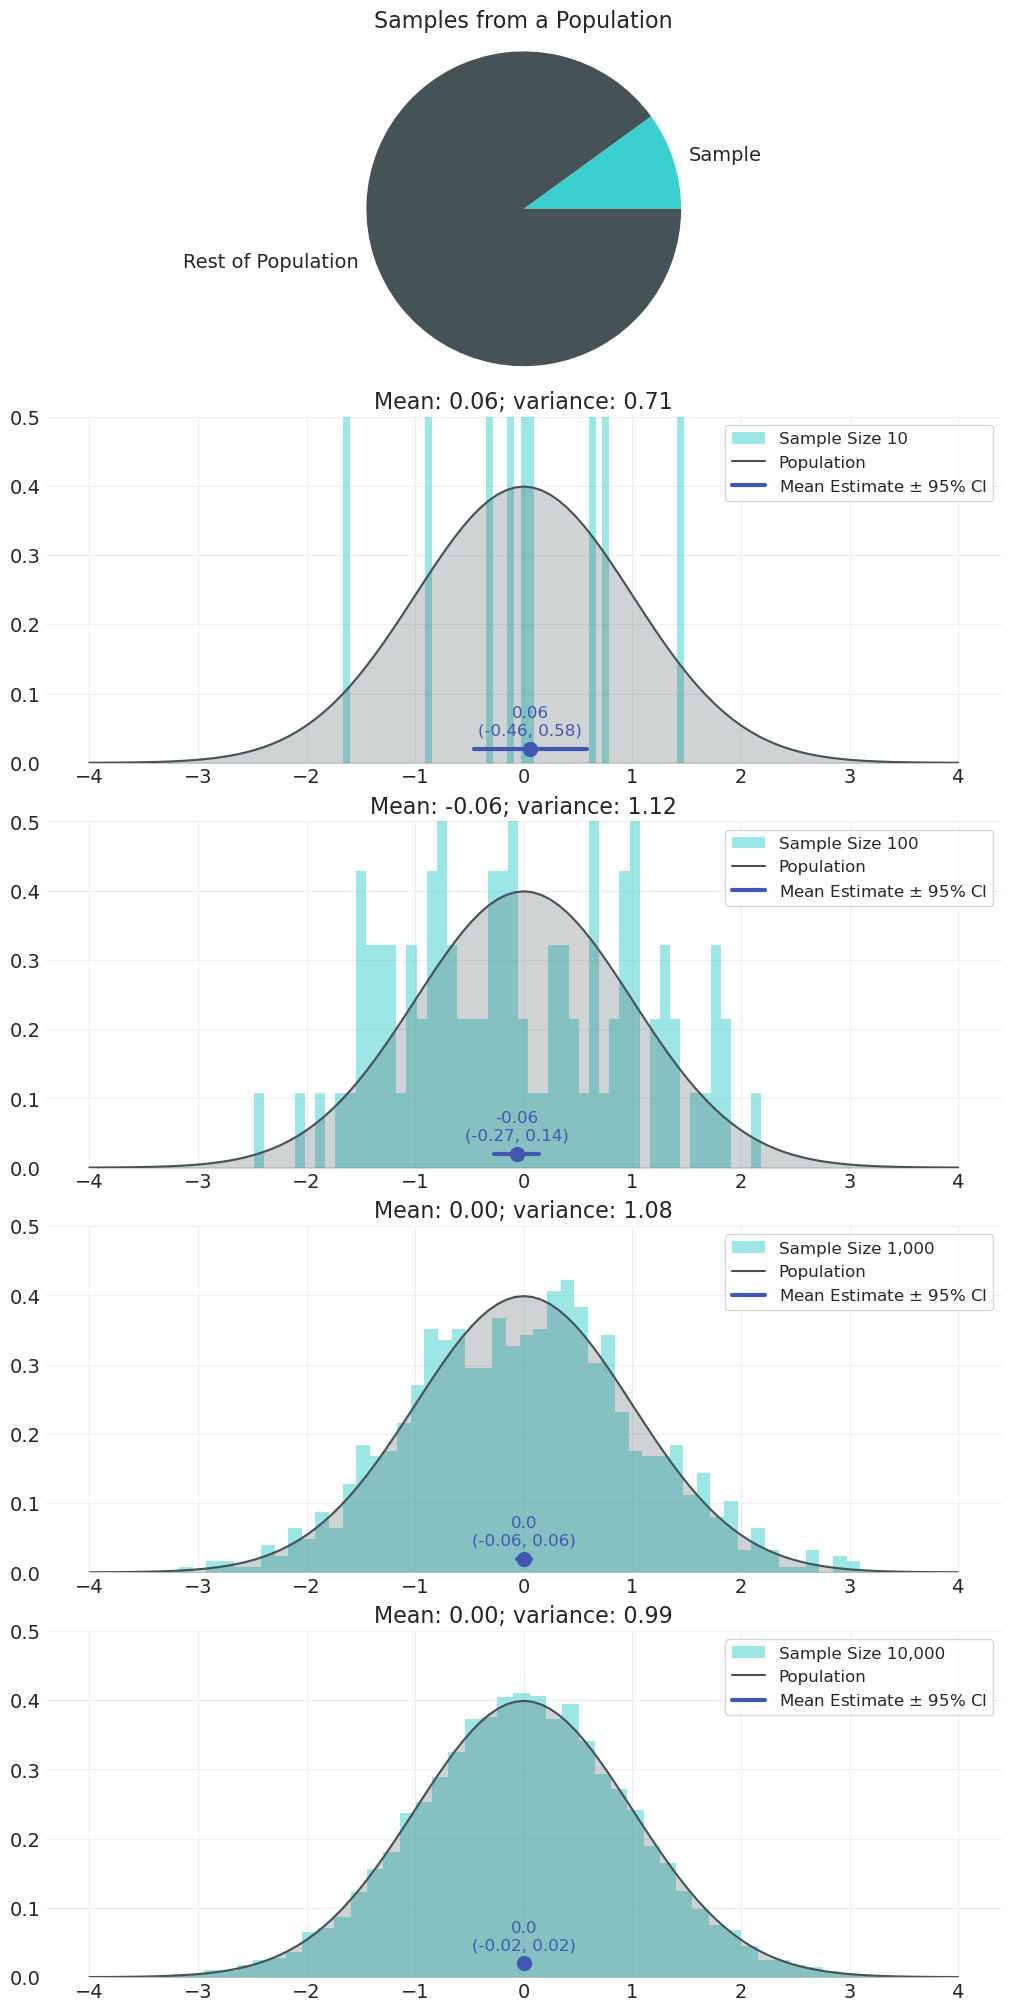

In [2]:
import os
from utils import plot_interval, Gaussian, Binomial, Poisson, COLORS
from scipy import stats

FIGS_DIR = '/tmp/figs/'
STD_NORMAL_COLOR = COLORS.gray
NULL_COLOR = 'black'
ALT_COLOR = COLORS.green
POPULATION_COLOR = COLORS.dark_gray
SAMPLES_COLOR = COLORS.cyan
INTERVAL_ESTIMATE_COLOR = COLORS.blue
ALPHA_COLOR = COLORS.yellow
BETA_COLOR = COLORS.dark_red
POWER_COLOR = COLORS.light_blue
SIMULATION_COLOR = COLORS.light_green



def savefig(fig_name):
    if FIGS_DIR:
        if not os.path.isdir(FIGS_DIR):
            os.makedirs(FIGS_DIR)
        plt.savefig(os.path.join(FIGS_DIR, fig_name + '.png'), dpi=300)

def confidence_interval(samples, confidence=.975):
    """
    Calculate the Gaussian confidence interval for the mean estimate for a set of samples
    
    Reference
    ---------
    http://www.stat.yale.edu/Courses/1997-98/101/confint.htm
    """
    z = stats.norm.ppf(confidence)
    mean = np.mean(samples)
    stderr = np.std(samples) / np.sqrt(len(samples))
    return mean, (mean - stderr * z, mean + stderr * z)


# Plot pie chart as cartoon demonstration of sampling from a population
_, axs = plt.subplots(5, figsize=(10, 20))
plt.sca(axs[0])
plt.pie(
    [1, 9],
    colors=[SAMPLES_COLOR, POPULATION_COLOR], labels=["Sample", "Rest of Population"]
);
plt.title("Samples from a Population")
plt.axis('square')


def plot_sample_distribution(sample_size):
    """
    Plot samples of `sample_size`, drawn from underlying standard Gaussian distribution
    """
    population = Gaussian(color=POPULATION_COLOR, label='Population')
    samples = population.sample(sample_size)
    ci = confidence_interval(samples)
    
    plt.hist(samples, label=f'Sample Size {sample_size:,}', density=True, color=SAMPLES_COLOR, alpha=.5, bins=50)
    population.plot()
    plot_interval(
        ci[1][0], ci[1][1], ci[0],
        y=.02, color=INTERVAL_ESTIMATE_COLOR, label=r'Mean Estimate $\pm$ 95% CI',
        display_text=True,
        fontsize=12,
        offset=.02
    )
    plt.axis('tight')
    plt.ylim([0, .5])
    plt.title('Mean: {:1.2f}; variance: {:1.2f}'.format(np.mean(samples), np.var(samples)))
    plt.legend();

# Demonstrate samples, CIs, and conversion to population for increasing sample sizes
for ii, sample_size in enumerate([10, 100, 1000, 10000]):
    plt.sca(axs[ii+1])
    plot_sample_distribution(sample_size)
savefig('sampling_cis')    

One type of statistical inference would be to determine whether there is a reliable relationship between independent and dependent variables associated with the population. Examples would include:
- determining the degree to which smoking (independent variable) increases the likelihood of contracting lung cancer (dependent variable)
- predicting the object labels in an image (dependent variables) based on an image's pixel values (independent variable).

Another type of statistical inference, one that will be the focus of this document, is determining if there is a real and reliable _difference between distinct groups_ in the population. For example, determining:
- Does a segment of the population that receives a drug treatment have reliably fewer negative symptoms compared to another segment that receives a placebo?
- Does formatting a website's welcome banner in Comic Sans result in a higher retention rate than the current banner formatted in Helvetica?

The last example is analogous to the standard setup of an **AB testing experiment** where a **variation** sample group of users experiences a particular version of a website (e.g. banner text formatted in Comic Sans), while a separate **control** sample group experiences the original website (e.g. banner text formatted in Helvetica).

Given this experimental setup, it is the job of the experimenter to determine if some **metric** of interest measured during the experiment (e.g. retention rate) is **significantly different between the two groups**. The magnitude and reliability of the difference is described through one or more **descriptive statistics** that are calculated on the sampled metric values and the significance of the difference is inferred by a **hypothesis test** that implements a particular **inference method** that is formulated based on those descriptive statistics (This document will address two classes of inference methods, namely Frequentist inference and Bayesian inference, and show how both can be easily implemented in ✨abracadabra✨).

### What exactly do we mean by "difference between groups"?

Before we cover hypothesis tests in more depth, let's take a step back and dig into what we actually mean by "difference between groups". What we'd like is a way to take two arrays of numbers $X_{sample}$, each associated with a sample from the populatoin, and return a single number that quantifies the "difference" (or similarity) between the two samples.

It turns out that there are quite a number of ways that samples can be compared, but a common apprach is to calculate some descriptive statistic that captures one or more properties about each of the samples' values, e.g.:
- **Central Tendencies of the sample distribution**--e.g $\text{mean}(X_a$)=$\mu_a$; median; mode
- **Spread of of the distribution**--e.g. range; standard deviation, $\text{std}(X_a$)=$\sigma_a$; variance, $\text{var}(X_a$)=$\sigma^2_a$
- **Shape of the distribution**--e.g. skewness, kurtosis

We then use a function that maps the descriptive statistics of the samples (or even the raw sample valuess) to a single, scalar that quantifies the difference/similarity between the samples. Examples include:

- **Deltas**--e.g. $\mu_b - \mu_a$
- **Ratios**--e.g. $\frac{\mu_b}{\mu_a}$
- **Divergences**--e.g. the [KL-divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) $\text{KL}(X_b || X_a)$

### Hypothesis Tests

Hypothesis tests set out to capture the multiple properties about the calculated differences that are informative for making decisions. In particular hypothesis tests attempt to capture:
- What is the **valence** of the difference? In other words, are the metrics associated with the variation group "better" or "worse" than the control's, or vice versa?
- What is the **magnitude** of the difference? In other words "how much" better or worse is one group's metric compared to the other?
- How **reliable** is the difference given in the presence of noise?

#### Quantifying comparison _valence_
For some scenarios the experimenter may simply want to determine if two samples are equal or unequal, with no consideration for the valence of the comparison. (This is the case when using a "two-tailed" Frequentist hypothesis test, but we'll get to that later). However,  for a majority of AB testing scenarious where the experimenter wants to make informed decisions to _improve_ the quality of a product, it is important to determine if the results associated with the `variation` group are "better" or "worse" than for the `control` group. This requires being able to quantify the valence of the comparison.

Quantifying valence will depend on the comparison function being used. For example, when using deltas, then the sign of the difference between the two samples can provide valence: positive sign indicates that the `variation` is "better" than the `control`, negative sign indicates "worse" results. When using ratio comparisons, it is the magnitude of the ratio, and its relation to the value one that provides valence. Ratios near one indicate little to no differnce between the two gropus, while ratios much larger than one indicate that the `variation` is performing better than the control; ratios less than one indicate poorer performance than the `control`.

#### Quantifying comparison magnitude: effect size
Not only do we care if a treatment group is "better" or "worse" than another group, but we also care about "how much" better or worse. This is where the ["effect size"](https://en.wikipedia.org/wiki/Effect_size) of comparison becomes important.

There are many definitions of effect size, each of which depends on the type of comparisons function we're employing. For example, when using deltas to compare means, one could simply take the magnitude of the difference between the means as an estimate of the effect size--i.e. $\mu_b - \mu_a$.

However, because all experiments involve sampling random variables--which are inherently noisy--it is generally a good idea to control for the degree of spread in the samples when calculating effect size. For example the Cohen's d is a commonly-used measure of effect size:

$$
\begin{align*}
d &= \frac{\mu_b - \mu_a}{\sigma_{pooled}}, \text{where} \\
\\
\sigma_{pooled} &= \sqrt{\frac{\sigma^2_a + \sigma^2_b}{2}}
\end{align*}
$$

This equation may appear somewhat complicated, but the most important thing to notice is that Cohen's d is simply the magnitude of the difference between the means, but rescaled by the amount of "spread" amongst the two groups. In this case "spread" is quantified as the pooled standard deviation $\sigma_{pooled}$. **Thus one can think of the Cohen's d effect size as a measure of "signal-to-noise" ratio:** how much of a difference can we detect between the two group means (signal),  while considering the spread of the groups (noise).

To demonstrate this idea graphically, below we plot two idealized Gaussian sample distributions while either increasing delta (signal) or increasing the variation group spread (noise). We then show how each of these manipulations effects the resulting Cohen's d effect size.


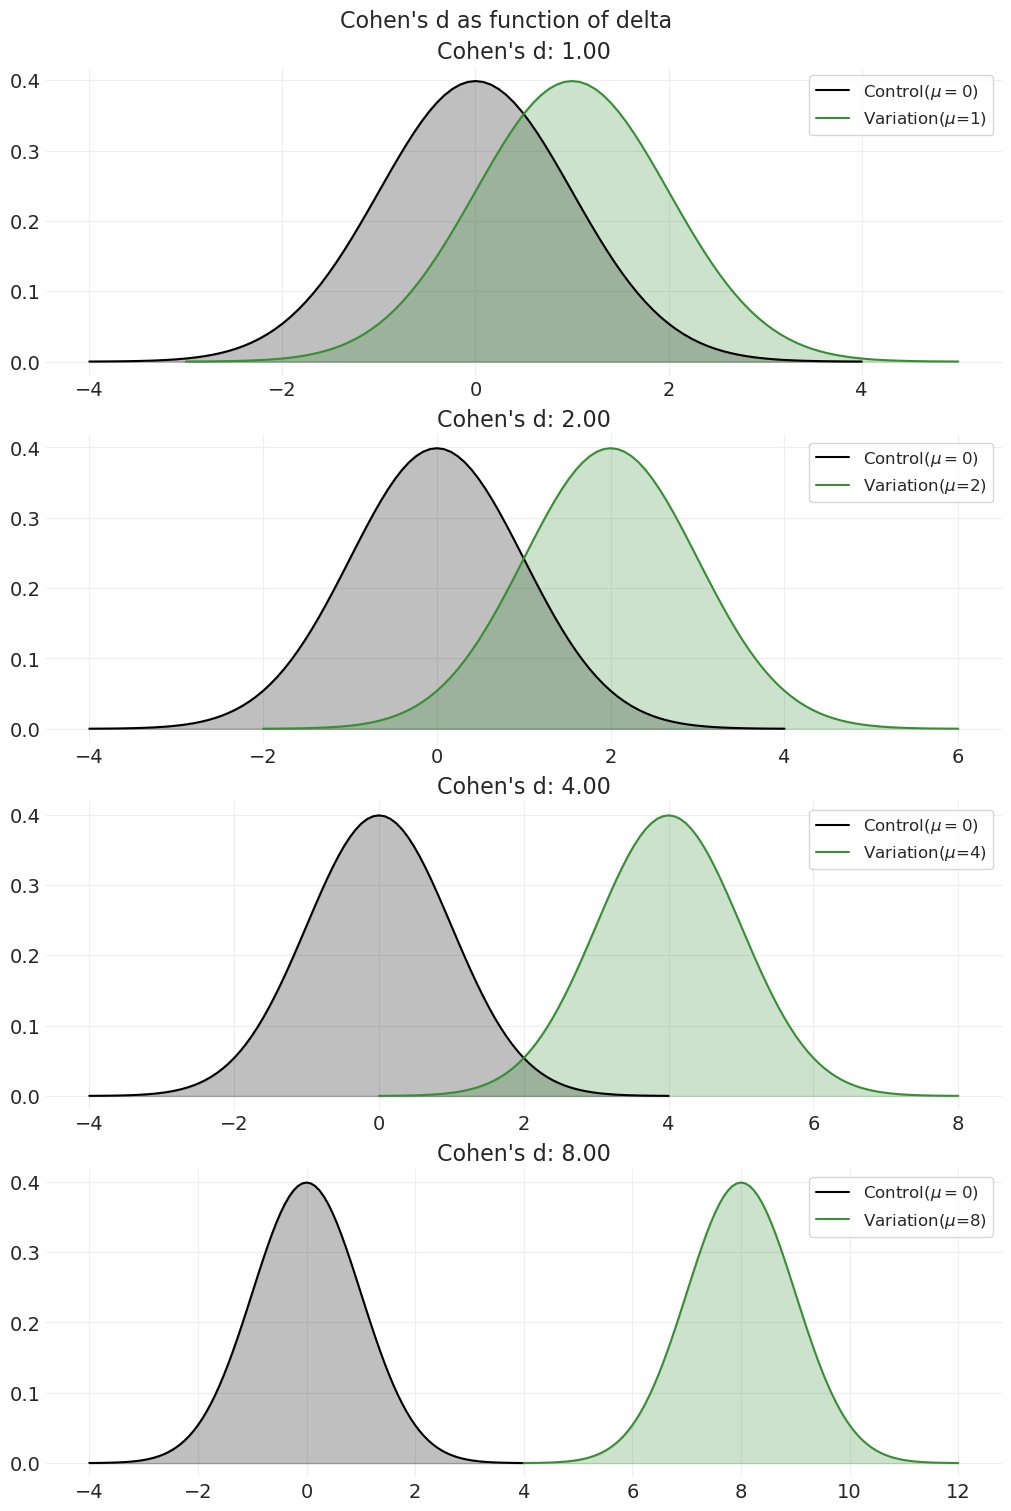

In [3]:
def cohens_d(delta, std_control, std_variation=None):
    std_variation = std_variation if std_variation else std_control
    std_pooled = np.sqrt((std_control**2 + std_variation**2) / 2.0)
    return delta / std_pooled

def plot_cohens_d_varying_means():
    variation_means = 2**np.arange(4)
    control = Gaussian(label='Control($\mu=0$)', color=NULL_COLOR)
    fig, axs = plt.subplots(4, figsize=(10, 15))
    for ii, vm in enumerate(variation_means):
        variation = Gaussian(mean=vm, label=f'Variation($\mu$={vm})', color=ALT_COLOR)
        plt.sca(axs[ii])
        control.plot()
        variation.plot()
        d = cohens_d(vm, control.std, variation.std)
        plt.title(f"Cohen's d: {d:1.2f}")
        plt.legend()
    plt.suptitle("Cohen's d as function of delta", fontsize=16)
        
def plot_cohens_d_varying_std():
    variation_std = 2**np.arange(4)
    variation_mean = 3
    control = Gaussian(label='Control(std=1)', color=NULL_COLOR)
    fig, axs = plt.subplots(4, figsize=(10, 15))
    for ii, vs in enumerate(variation_std):
        variation = Gaussian(mean=variation_mean, std=vs, label=f'Variation(std={vs})', color=ALT_COLOR)
        plt.sca(axs[ii])
        control.plot()
        variation.plot()
        d = cohens_d(vs, control.std, variation.std)
        plt.title(f"Cohen's d: {d:1.2f}")
        plt.legend()
    plt.suptitle("Cohen's d as function of std", fontsize=16)
        
plot_cohens_d_varying_means()
savefig('cohens_d_delta')

We see that increasing the magnitude of $\mu_{variation} - \mu_{control}$ while keeping the std constant increases the calculated value of Cohen's d. Now let's see what happens if we hold the means fixed but increase the standard deviation of the variation group (control group held constant).

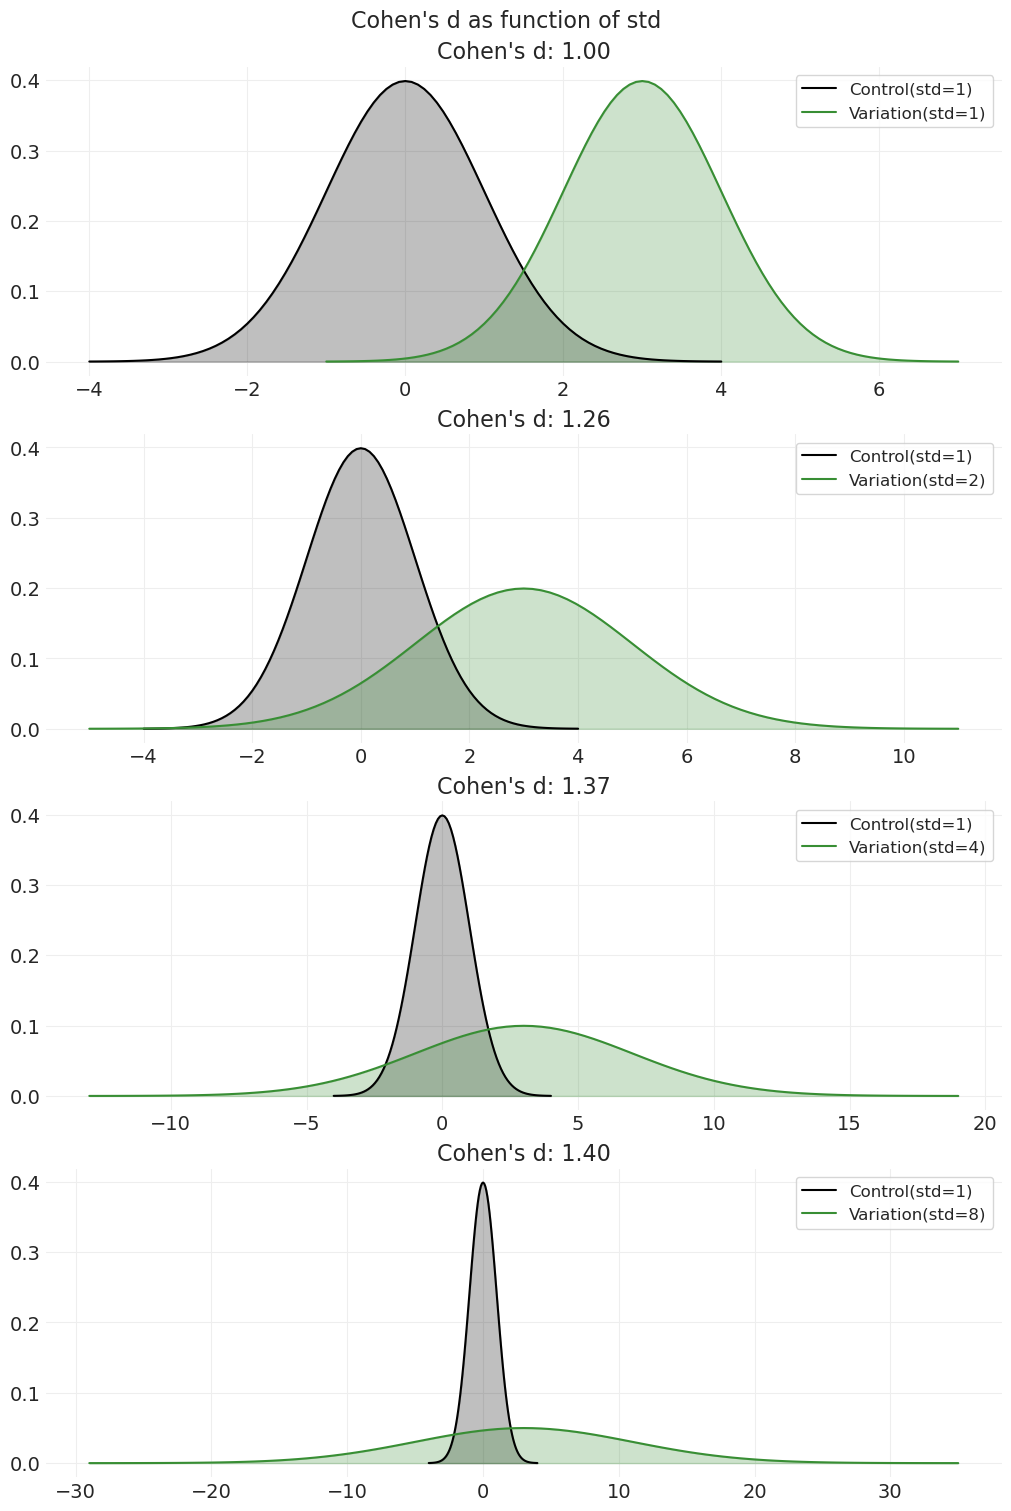

In [4]:
plot_cohens_d_varying_std()
savefig('cohens_d_std')

We can see that increasing the pooled standard deviation while keeping the value of $\mu_{variation} - \mu_{control}$ constant decreases the effect size.

As we'll see shortly, understanding how effect size is related to BOTH the difference between groups AND the spread of each group is important when planning and interpreting the results of experiments.

#### Quantifying the reliability of differences
Samples are never perfect and there is always noise in the system. How confident can we be about the decisions made based on the output of hypothesis tests.

#### Quantifying magnitude and effect size
Not only do we care if a treatment group is "better" or "worse" than another group, but we also care about "how much" better or worse one group is compared to another. This is where the ["effect size"](https://en.wikipedia.org/wiki/Effect_size) of comparison becomes important.

There are many definitions of effect size each of which depends on the type of comparisons we're employing. For example, when using deltas, the Cohen's d measure is commonly used:

$$
\begin{align*}
d &= \frac{\mu_b - \mu_a}{\sigma_{pooled}}, \text{where often} \\
\\
\sigma_{pooled} &= \sqrt{\frac{\sigma^2_a + \sigma^2_b}{2}}
\end{align*}
$$


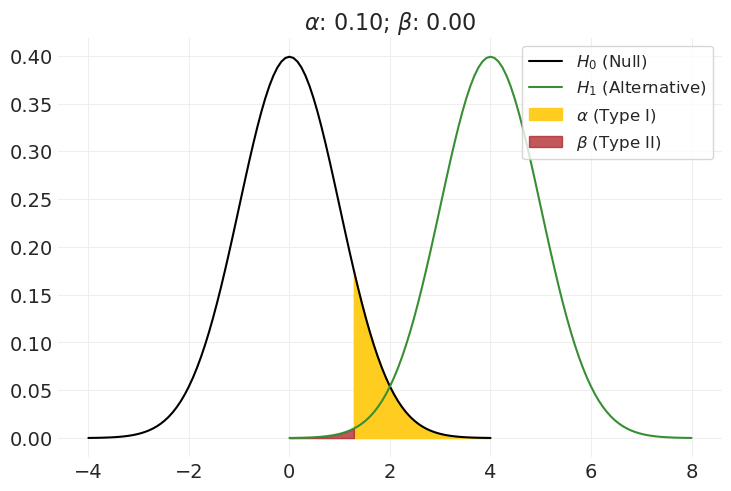

In [5]:
def plot_alpha_beta(alpha=.05, null_mean=0, null_std=1, alt_mean=4, alt_std=1, plot_power=False):
    """Visualize the relationship between Type I and Type II error (assuming right-tailed test),
    assuming Gaussian Null and Alternative hypothesis parameterizations.
    """
    null = Gaussian(mean=null_mean, std=null_std, label='$H_0$ (Null)', color=NULL_COLOR, fill=False)
    alternative = Gaussian(mean=alt_mean, std=alt_std, label='$H_1$ (Alternative)', color=ALT_COLOR, fill=False)

    x_at_alpha = null.ppf(1-alpha)  # one-tailed
    x_alpha = np.linspace(x_at_alpha, null.xgrid().max())
    
    beta = alternative.cdf(x_at_alpha)
    x_beta = np.linspace(alternative.xgrid().min(), x_at_alpha)
    
#     plt.subplots(figsize=(10, 5)) 
    
    # Plot distributions
    null.plot()
    alternative.plot()
    
    # Plot errors
    null.plot_area(x_alpha, alpha=1, color=ALPHA_COLOR, label=r'$\alpha$ (Type I)')
    alternative.plot_area(x_beta, alpha=.75, color=BETA_COLOR, label=r'$\beta$ (Type II)')
    
    # Plot power
    if plot_power:
        power = 1 - beta
        x_power = np.linspace(x_at_alpha, alternative.xgrid().max())
        alternative.plot_area(x_power, alpha=.5, color=POWER_COLOR, label=r'Power (1-$\beta$)')
        plt.title(r"$\alpha$: {:1.2f}; $\beta$: {:1.2f}; Power: {:1.2f}".format(alpha, beta, power))
    else:
        plt.title(r"$\alpha$: {:1.2f}; $\beta$: {:1.2f}".format(alpha, beta))
    plt.legend()

plot_alpha_beta(.1)
savefig('alpha_beta.png')

## Inferential Statistics
- Effect Size
- Type I rate
- Power

## Central Limit Theorem, Standard Errors, and Confidence Intervals

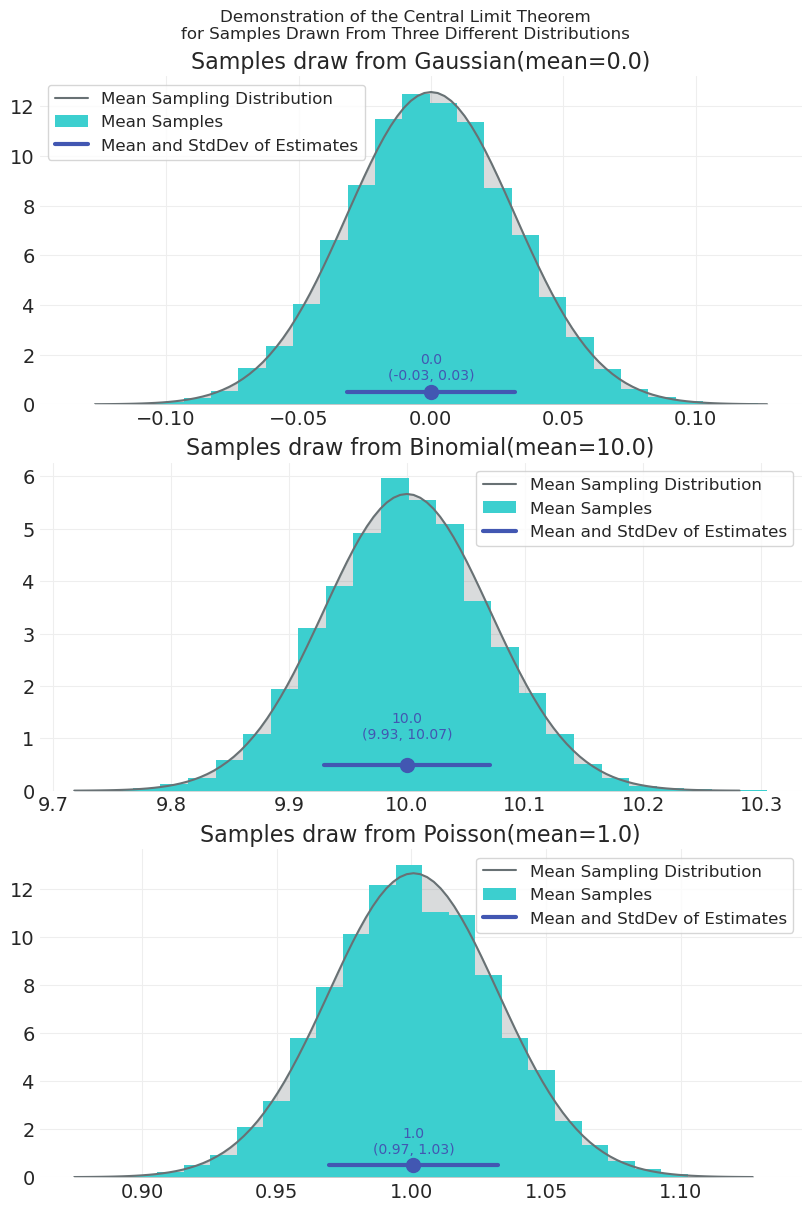

In [6]:
n_samples, n_trials = 1000, 10000
fig, axs = plt.subplots(3, figsize=(8, 12))
distribution_classes = [Gaussian, Binomial, Poisson]
for ii, distribution_class in enumerate(distribution_classes):
    plt.sca(axs[ii])
    distribution = distribution_class()

    # Draw samples form the distribution over multiple trials
    samples = distribution.sample(size=(n_samples, n_trials))
    
    # Estimate mean for all trials
    means = samples.mean(0)
    
    # Estimate mean and StdDev of mean estiamte
    mean_estimate = means.mean()
    std_estimate = means.std()
    
    # Demonstrate the CLT, namely that means over trials are Gaussian-distributed
    CLT = Gaussian(mean_estimate, std_estimate, label='Mean Sampling Distribution', color=STD_NORMAL_COLOR)
    CLT.plot()
    plt.hist(means, color=SAMPLES_COLOR, bins=25, density=True, label='Mean Samples')
    plot_interval(
        mean_estimate - std_estimate, mean_estimate + std_estimate, mean_estimate,
        color=INTERVAL_ESTIMATE_COLOR,
        label="Mean and StdDev of Estimates",
        y=.5,
        display_text=True,
        offset=.5,
        fontsize=10
    )
    plt.title(f"Samples draw from {distribution.__class__.__name__}(mean={distribution.dist.mean()})")
    plt.legend()
    plt.suptitle("Demonstration of the Central Limit Theorem\nfor Samples Drawn From Three Different Distributions")
    
savefig('central_limit_theorem')

### Standard Error of the Mean

The standard error of the mean of one sample is an estimate of the standard deviation that would be obtained from the means of a large number of samples drawn from that population.

$$
\begin{align*}
SE &= \sqrt{\frac{\sigma^2}{n}} \\
&= \frac{\sigma}{\sqrt{n}} \\
\end{align*}
$$

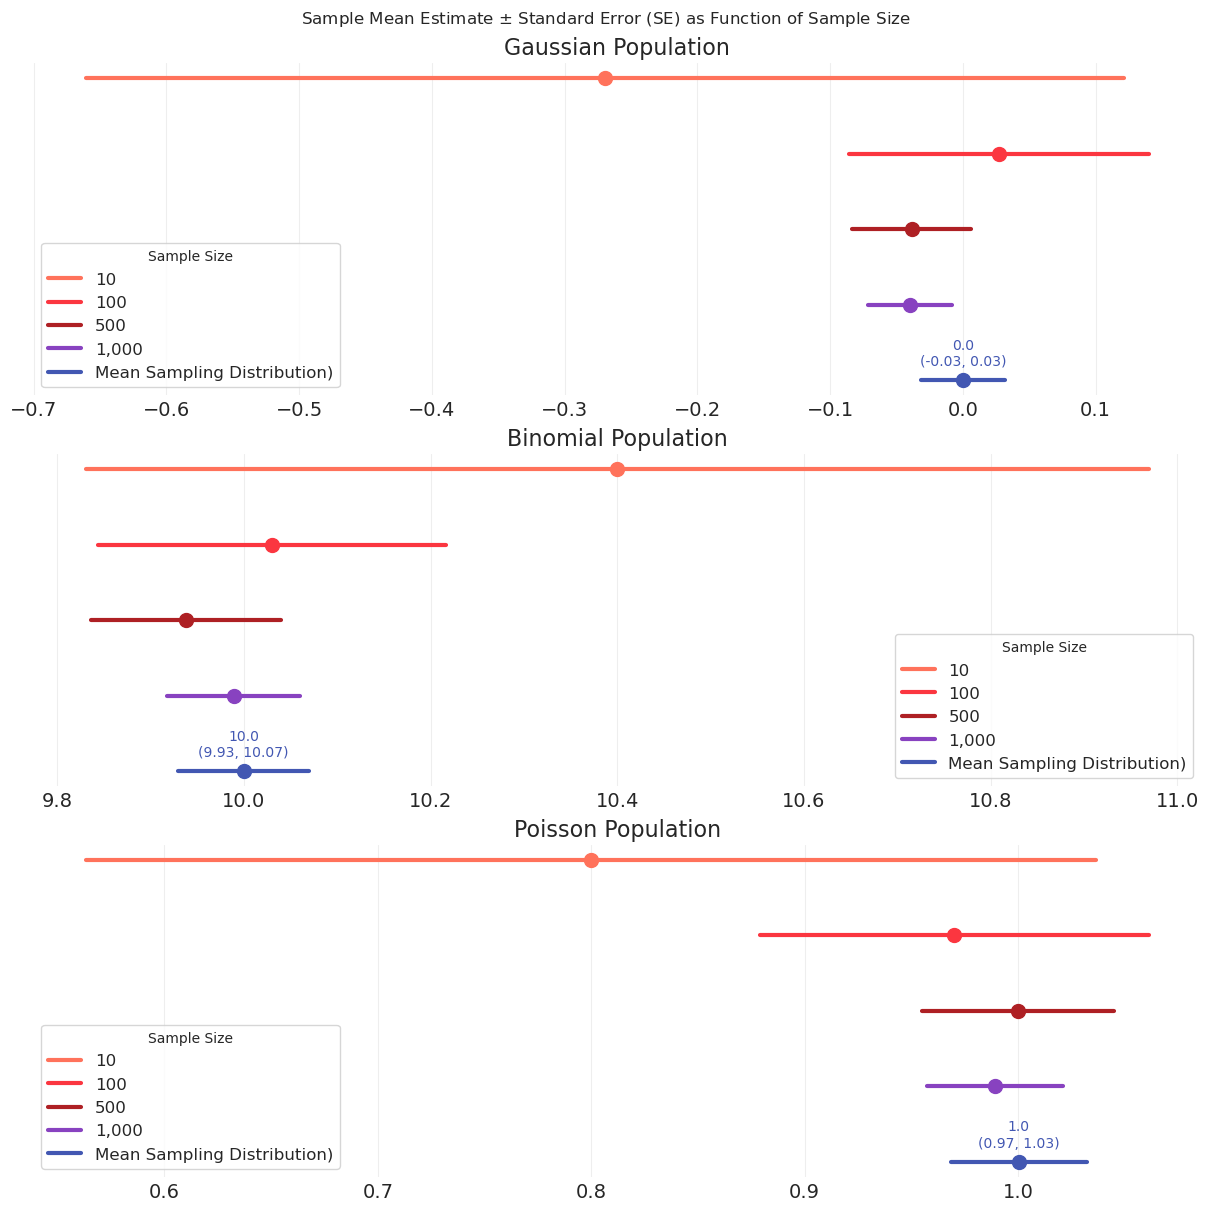

In [7]:
def simulate_std_err(population, n_samples):
    np.random.seed(123)
    samples = population.sample(n_samples)
    mean = np.mean(samples)
    std_error = np.std(samples) / np.sqrt(n_samples)
    return mean, std_error, samples

n_samples, n_trials = 1000, 1000
ci_colors = [
    COLORS.salmon,
    COLORS.red,
    COLORS.dark_red,
    COLORS.purple
]

fig, axs = plt.subplots(3, figsize=(12, 12))
for ii, distribution_class in enumerate(distribution_classes):
    plt.sca(axs[ii])
#     plt.subplots(figsize=(12, 3))
    distribution = distribution_class()
    clt_samples = distribution.sample(size=(n_samples, n_trials))

    # Estimate mean for all trials
    means = clt_samples.mean(0)

    # Estimate mean and StdDev of mean estiamte
    mean_estimate = means.mean()
    std_estimate = means.std()
    
    estimation_sample_sizes = [10, 100, 500, 1000]
    for jj, n_samples in enumerate(estimation_sample_sizes):
        mean, std_error, samples = simulate_std_err(distribution, n_samples)
        plot_interval(mean-std_error, mean+std_error, mean, y=4-jj, color=ci_colors[jj], label=f"{n_samples:,}")
        plt.title(f'{distribution.__class__.__name__} Population')


    plot_interval(
        mean_estimate-std_estimate,
        mean_estimate+std_estimate,
        mean_estimate, y=0,
        color=COLORS.blue,
        label=r'Mean Sampling Distribution)',
        display_text=True,
        offset=.2,
        fontsize=10
    )
    plt.yticks([])
    plt.legend(title='Sample Size')
    plt.suptitle("Sample Mean Estimate $\pm$ Standard Error (SE) as Function of Sample Size")
    savefig('standard_error_convergence')

### Pooled Standard Error
$$
\begin{align*}
z &= \frac{\mu_a - \mu_b}{\text{SE}_{pooled}}, \text{where} \\
\\
\text{SE}_{pooled} &= \sqrt{\frac{\sigma^2_a}{n_a} + \frac{\sigma^2_b}{n_b}}
\end{align*}
$$

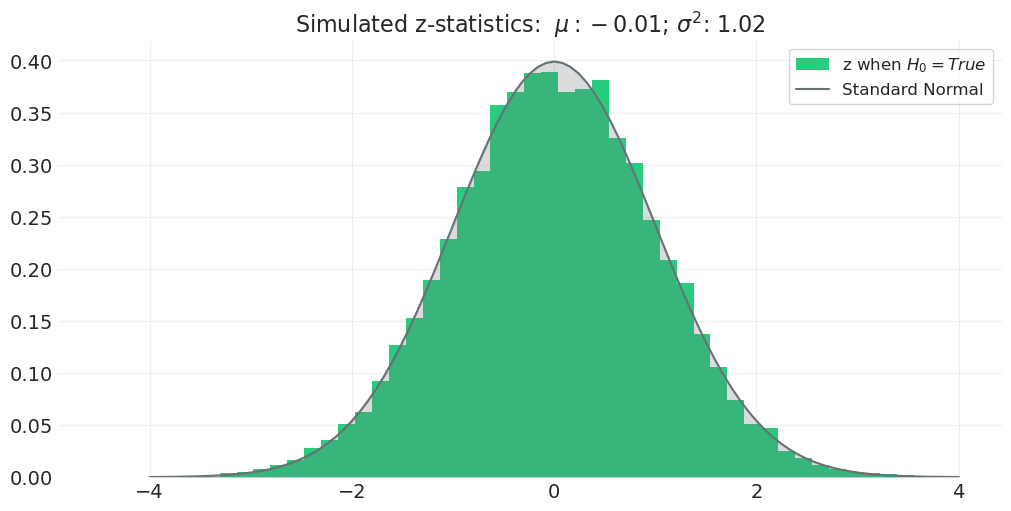

In [8]:
def simulate_z(n_simulations=20000, n_observations=100):
    z_statistics = []
    null = alternative = Gaussian()
    
    for _ in range(n_simulations):
        
        # no difference in random variables
        null_samples = null.sample(n_observations)
        alt_samples = alternative.sample(n_observations)
        
        mean_null = np.mean(null_samples)
        mean_alt = np.mean(alt_samples)
        
        variance_null = np.var(null_samples)
        variance_alt = np.var(alt_samples)
        
        pooled_std_error = np.sqrt(variance_null / n_observations + variance_alt / n_observations)
        
        z_statistic = (mean_alt - mean_null) / pooled_std_error
        z_statistics.append(z_statistic)
        
    return z_statistics

simulated_z = simulate_z()
plt.subplots(figsize=(10, 5))
plt.hist(simulated_z, density=True, bins=50, color=SIMULATION_COLOR, label=r'z when $H_0=True$')
standard_normal = Gaussian(mean=0, std=1, color=STD_NORMAL_COLOR, label='Standard Normal')
standard_normal.plot()
plt.title(r'Simulated z-statistics:  $\mu: {:1.2f}$; $\sigma^2$: {:1.2f}'.format(np.mean(simulated_z), np.var(simulated_z)))
plt.legend();

### Type I  Error ($\alpha$), Type II Error ($\beta$), and Inferential Power



|   |$H_0$ is True|$H_0$ is False|
|---|---|---|
|Reject $H_0$|<span style="color:#FB3640">False Positive</span>| <span style="color:#388E34">True Negative</span>||
|Fail to Reject  $H_0$| <span style="color:#388E34">True Positive</span>|<span style="color:#FB3640">False Negative</span>||

#### Type I and Type II Errors

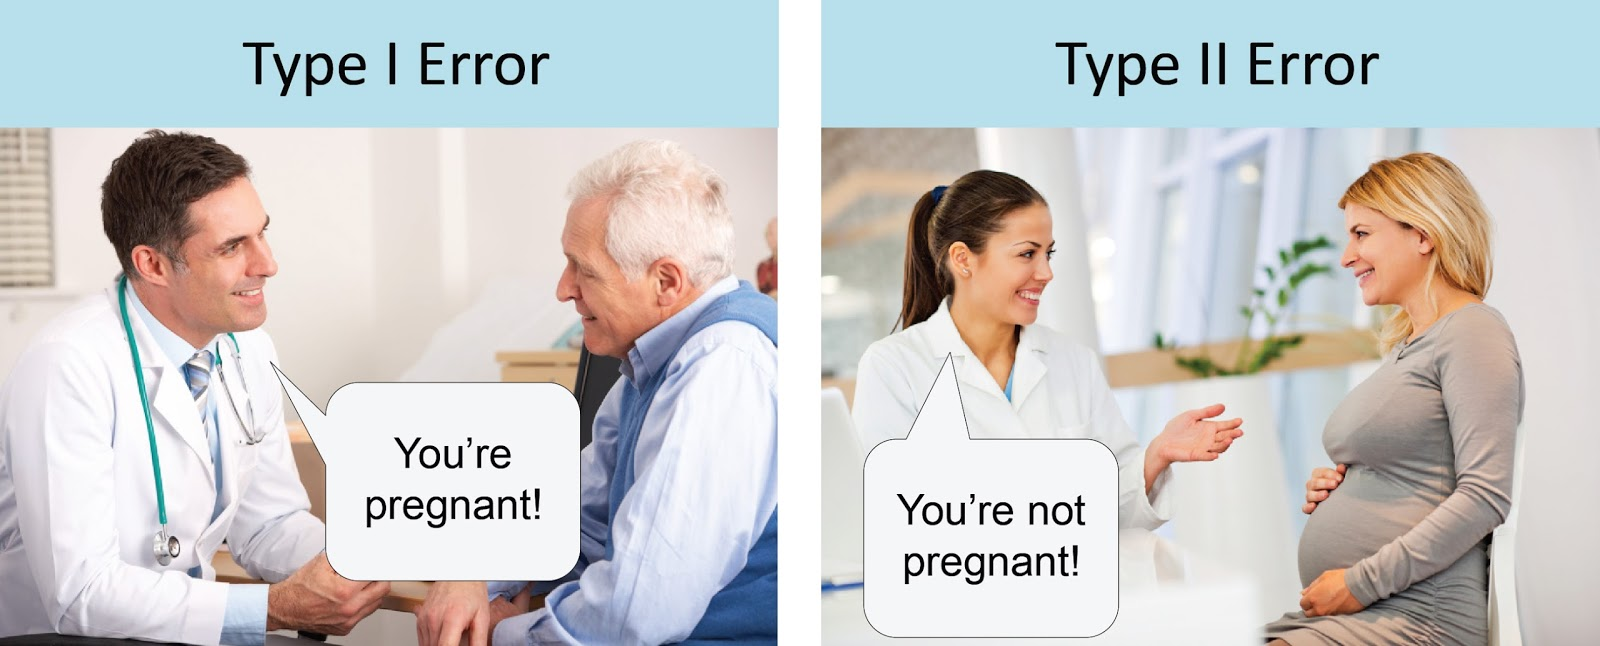

In [9]:
typeiandtypeiierror_url = "https://shuzhanfan.github.io/assets/images/typeiandtypeiierror.jpg"
from IPython.display import Image
Image(
    url=typeiandtypeiierror_url,
    retina=True, embed=True,
    metadata={"source": typeiandtypeiierror_url}
)

### Power
Power: the probability that a test will _correctly_ give you a small p-value

What affects power:
- effect size
- spread in the distributions
- (in the case of hypothesis testing), the alpha value used
- sample size: this can account for small effect size and/or large spread

What you need to calculate power:
- effect size
- variation
- sample size
- alpha

In [10]:
def rug(samples, y=.01, color='black'):
    """Simple util to add rug plot to current a"""
    plt.gca().plot(samples, np.ones(len(samples)) * y, 'o', color=color, markersize=8)

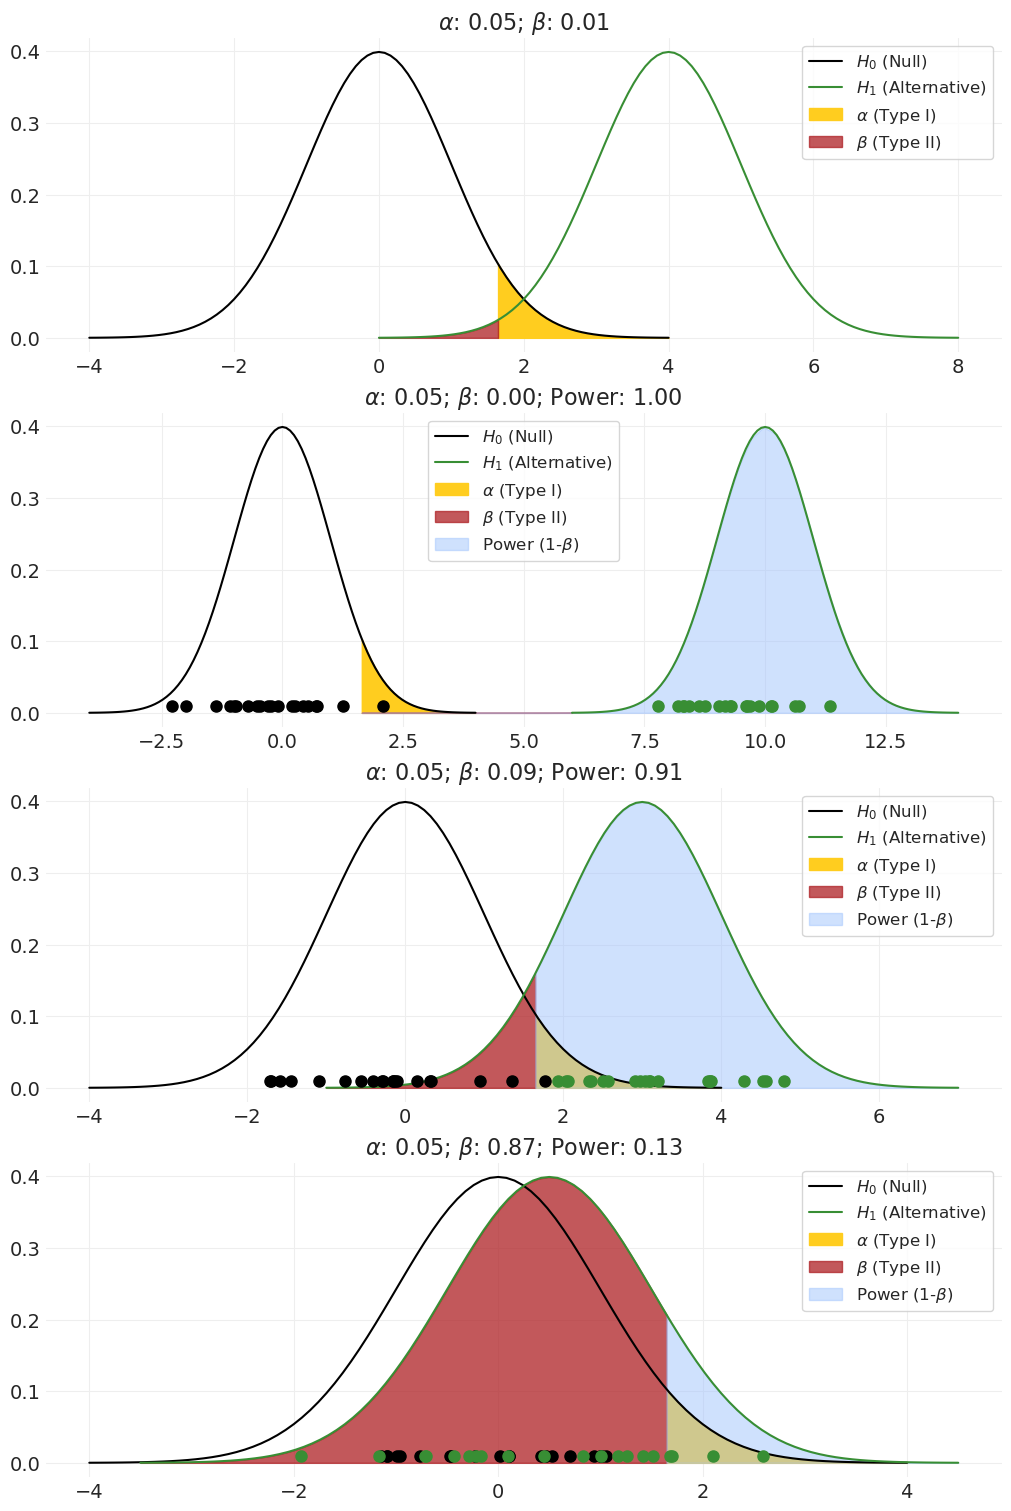

In [11]:
fig, axs = plt.subplots(4, figsize=(10, 15))
plt.sca(axs[0])
plot_alpha_beta()
for ii, alt_mean in enumerate([10, 3, .5]):
    plt.sca(axs[ii+1])
    plot_alpha_beta(alt_mean=alt_mean, plot_power=True)
    null_samples = Gaussian().sample(20)
    rug(null_samples, color=NULL_COLOR)
    alt_samples = Gaussian(mean=alt_mean).sample(20)
    rug(alt_samples, color=ALT_COLOR)
    
    
savefig('high_low_power')

#### Power vs effect size

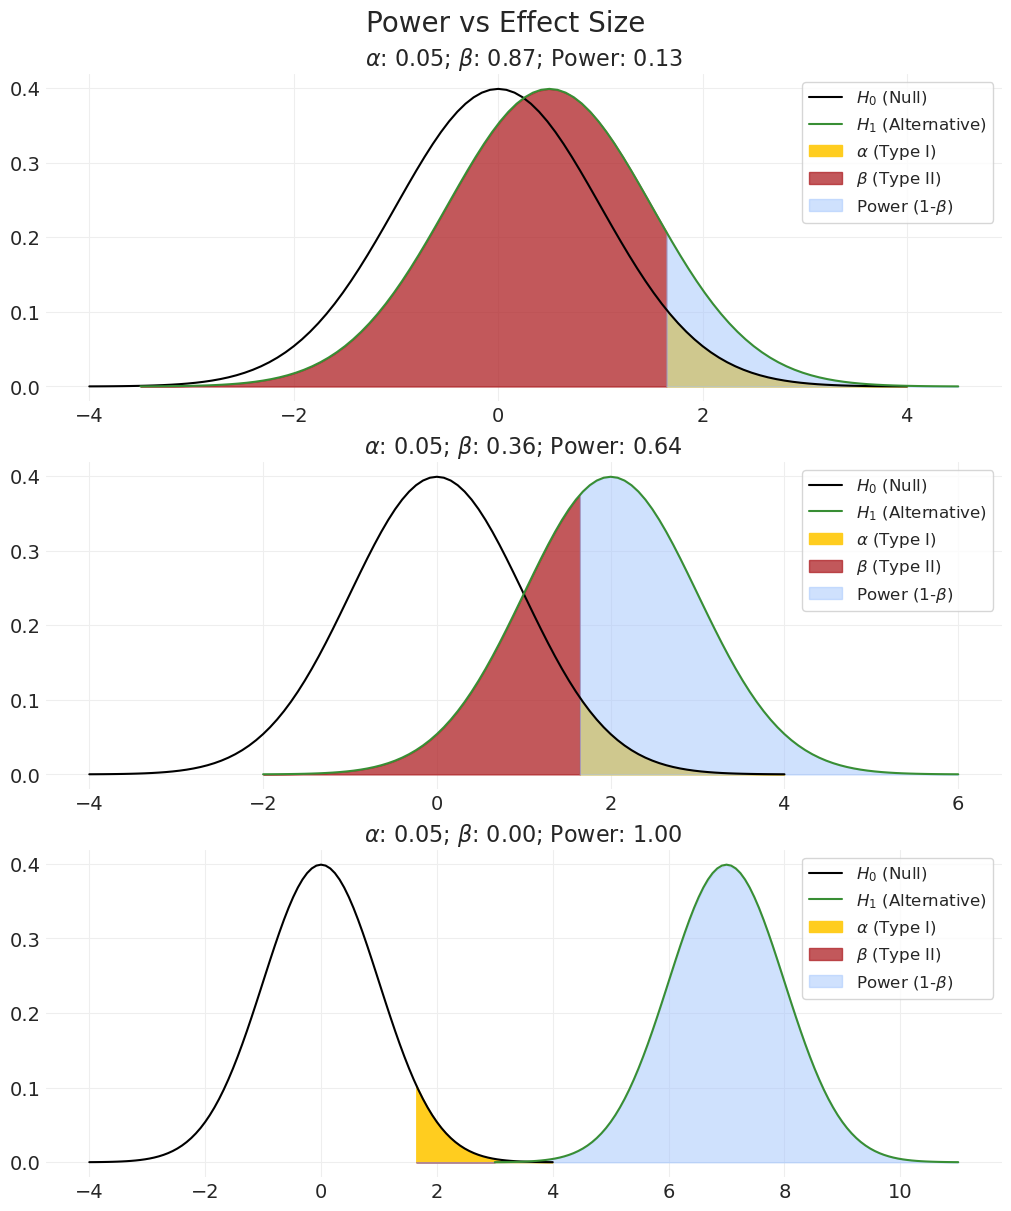

In [12]:
fig, axs = plt.subplots(3, figsize=(10, 12))
alpha = .05
for ii, alt_mean in enumerate([.5, 2, 7]):
    plt.sca(axs[ii])
    plot_alpha_beta(alpha=alpha, alt_mean=alt_mean, plot_power=True)
plt.suptitle('Power vs Effect Size', fontsize=20)
savefig('power_vs_effect_size')

#### Power vs distribution variance

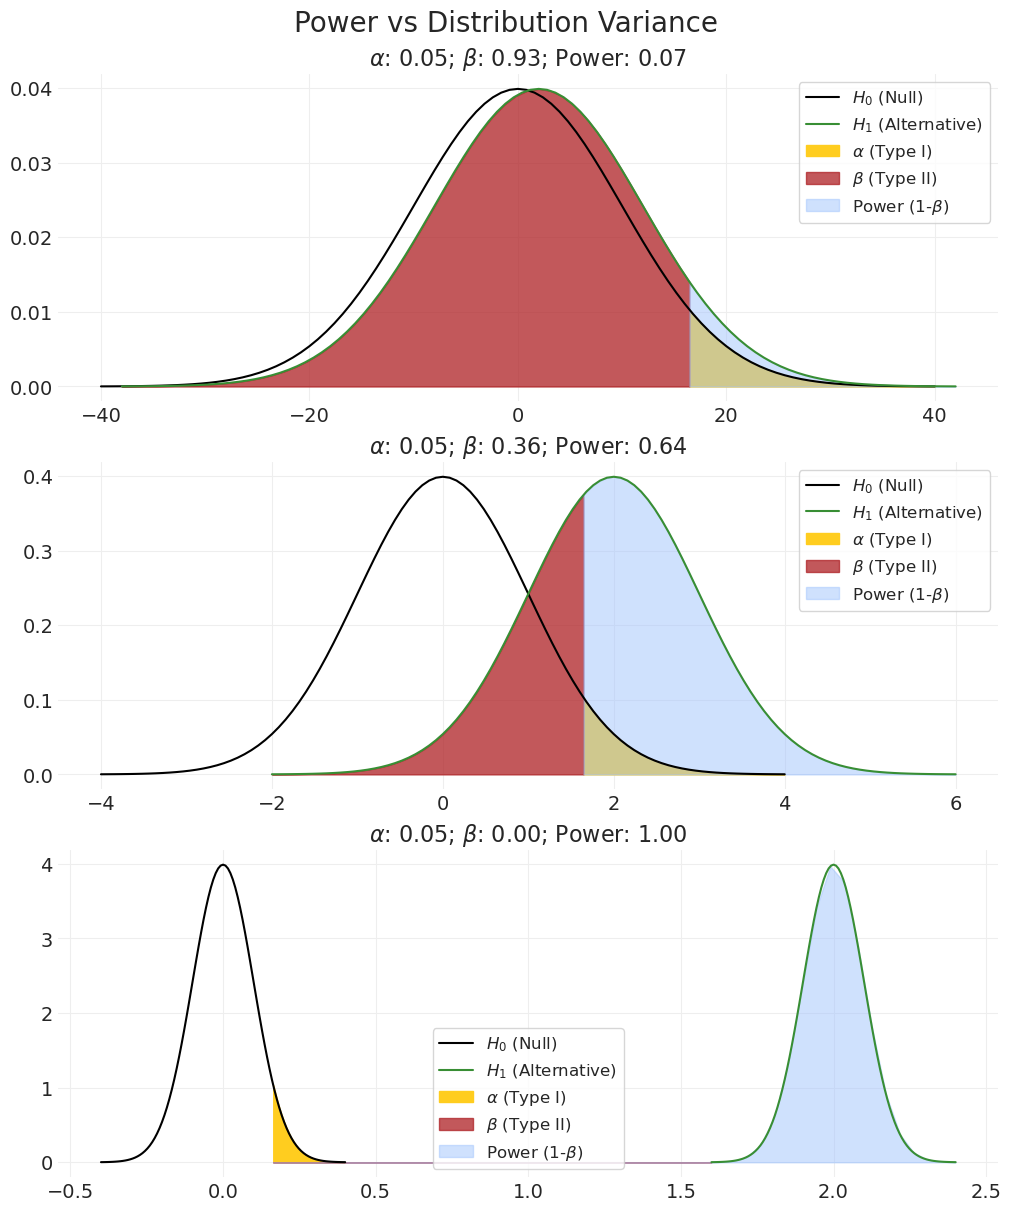

In [13]:
fig, axs = plt.subplots(3, figsize=(10, 12))
for ii, std in enumerate([10, 1, .1]):
    plt.sca(axs[ii])
    plot_alpha_beta(alpha=alpha, null_std=std, alt_mean=2, alt_std=std, plot_power=True)
plt.suptitle('Power vs Distribution Variance', fontsize=20)
savefig('power_vs_std')

#### Power vs $\alpha$

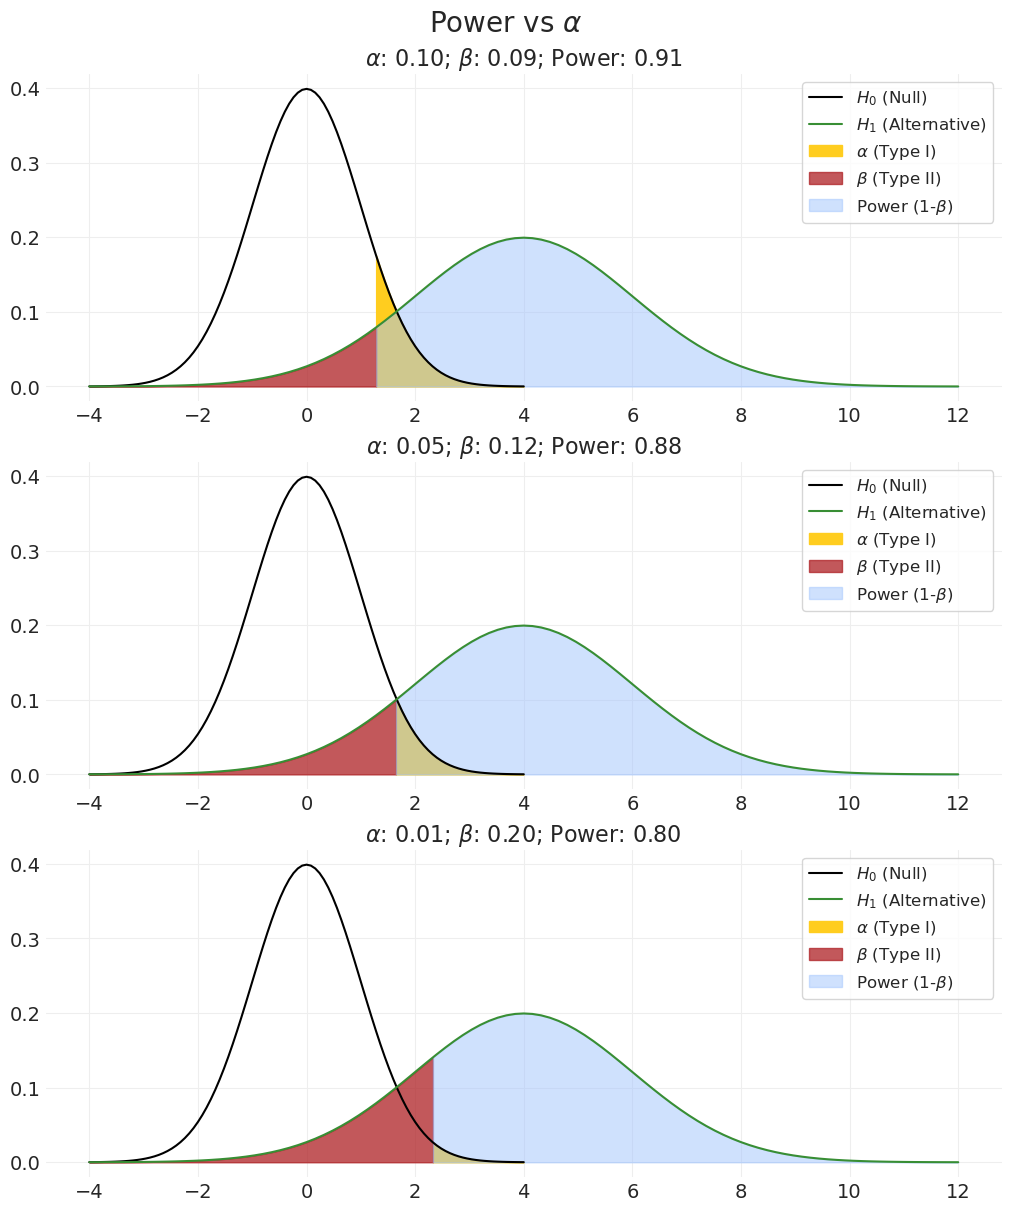

In [14]:
fig, axs = plt.subplots(3, figsize=(10, 12))
for ii, alpha in enumerate([.1, .05, .01]):
    plt.sca(axs[ii])
    plot_alpha_beta(alpha=alpha, alt_std=2, plot_power=True)

plt.suptitle(r'Power vs $\alpha$', fontsize=20)
savefig('power_vs_alpha')

#### Power vs Sample Size

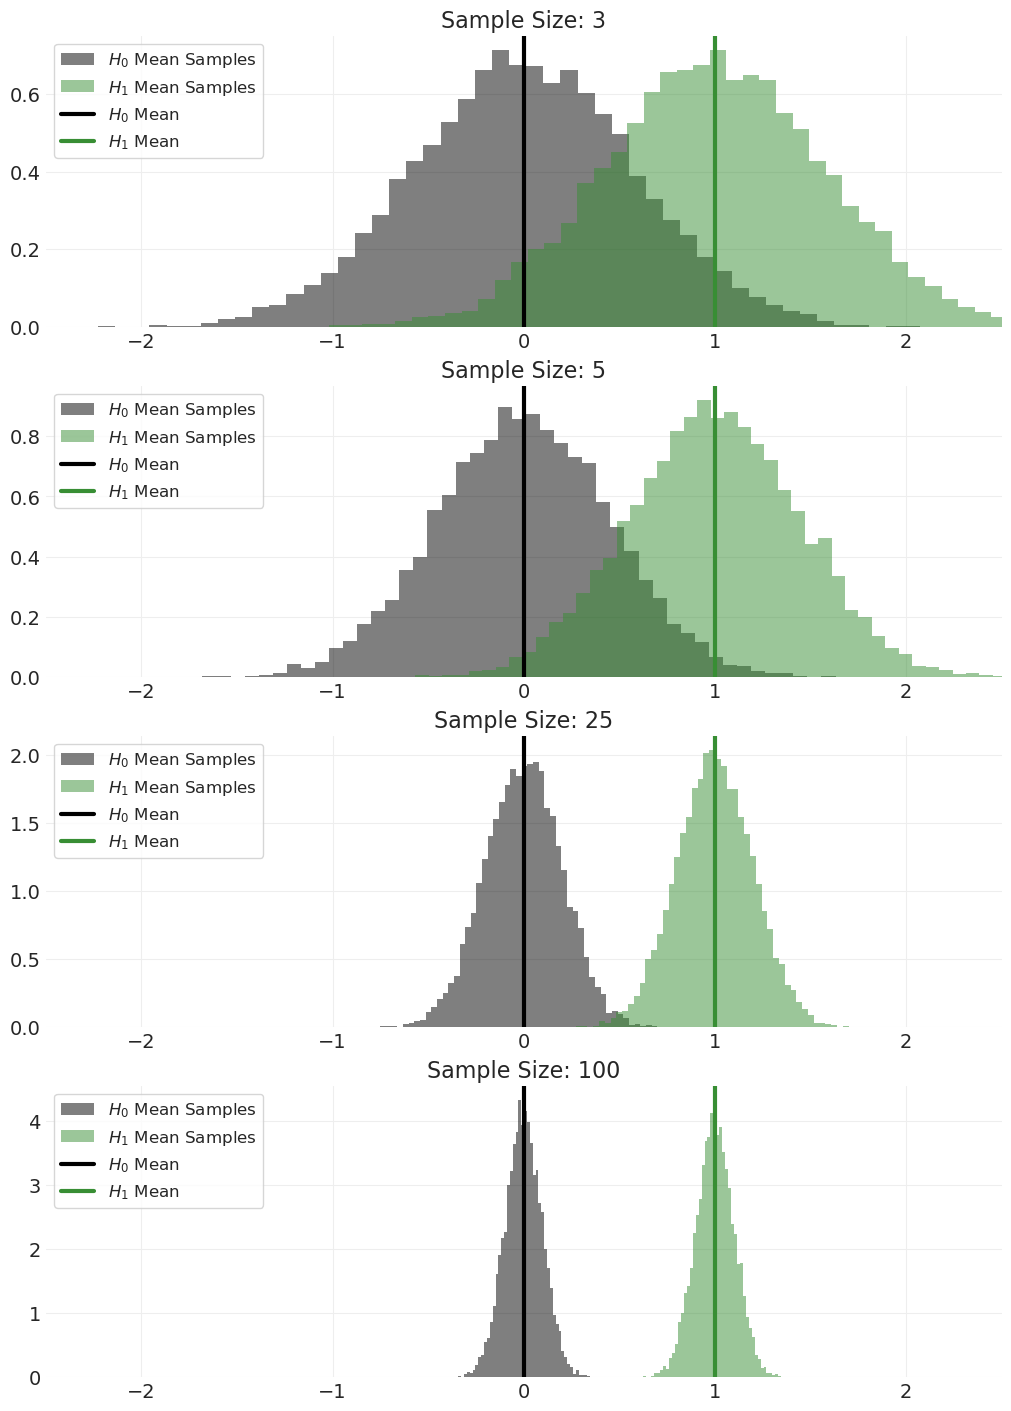

In [15]:
def simulate_mean_estimates(n_mean=10, n_alt=10, n_trials=10000, null_mean=0, null_std=1, alt_mean=1, alt_std=1):
    null = Gaussian(mean=null_mean, std=null_std, color=NULL_COLOR)
    alt = Gaussian(mean=alt_mean, std=alt_std, color=ALT_COLOR)
    null_means = null.sample((n_mean, n_trials)).mean(0)
    alt_means = alt.sample((n_alt, n_trials)).mean(0)
    
    plt.hist(null_means, color=null.color, bins=50, alpha=.5, density=True, label=r'$H_0$ Mean Samples')
    plt.hist(alt_means, color=alt.color, bins=50, alpha=.5, density=True, label=r'$H_1$ Mean Samples')
    plt.axvline(null_mean, label='$H_0$ Mean', color=null.color, linewidth=3)
    plt.axvline(alt_mean, label='$H_1$ Mean', color=alt.color, linewidth=3)
    plt.legend(loc='upper left')
    

n_samples_range = [3, 5, 25, 100]
fig, axs = plt.subplots(len(n_samples_range), figsize=(10, 14))
for ii, n_samples in enumerate(n_samples_range):
    plt.sca(axs[ii])
    simulate_mean_estimates(n_mean=n_samples, n_alt=n_samples)
    plt.xlim((-2.5, 2.5))
    plt.title(f"Sample Size: {n_samples}")

## Frequentist Approach to Inference

### Frequentist Testing Gotcha

#### Data Peeking

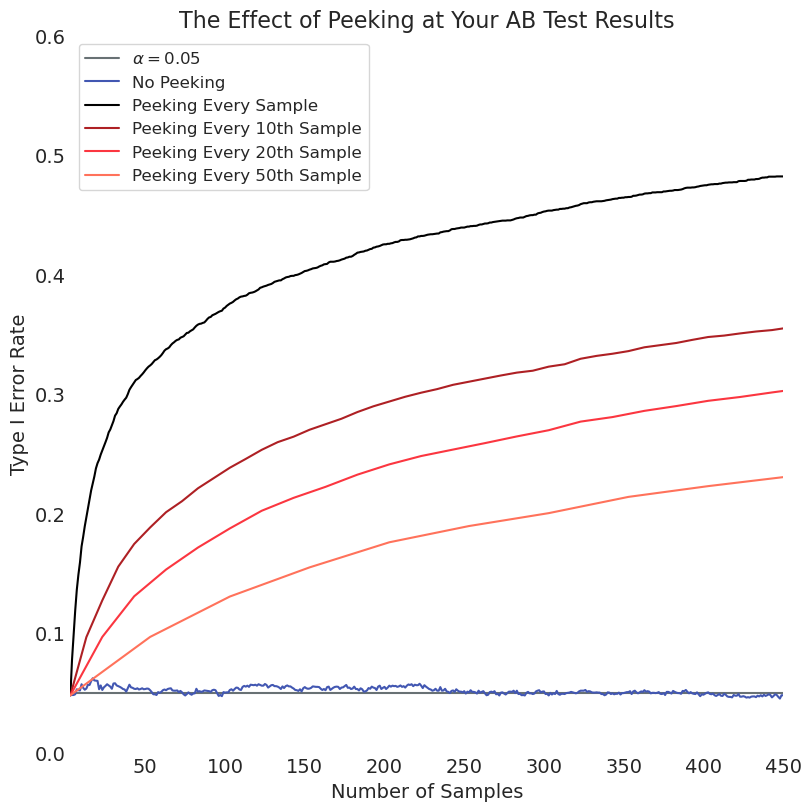

In [16]:
alpha = .05
n_samples_per_trial, n_trials = 500, 5000
simulations = Gaussian().sample(size=(n_samples_per_trial, n_trials))

min_samples = 3
results = []
n_samples = []
for n_samples_used in range(min_samples, n_samples_per_trial):
    n_samples.append(n_samples_used)
    results.append(stats.ttest_1samp(simulations[:n_samples_used], 0., axis=0).pvalue)

results = np.array(results)
decisions = results <= alpha
type_I_error_rate = decisions.mean(axis=1)
       
plt.subplots(figsize=(8, 8))
plt.axhline(alpha, color=COLORS.gray, label=r'$\alpha={:0.2f}$'.format(alpha))
plt.plot(n_samples, type_I_error_rate, color=COLORS.blue, label='No Peeking')

    
# Simulate "Peeking" by considering all observations after an initial
# positive result to be considered positive
continuous_peeking_decisions = decisions.cumsum(axis=0) >= 1
continuous_peeking_type_I_error_rate = continuous_peeking_decisions.mean(1)

check_every_colors = [
    COLORS.dark_red,
    COLORS.red,
    COLORS.salmon
]

plt.plot(n_samples, continuous_peeking_type_I_error_rate, color='black', label='Peeking Every Sample')
peaking_strategy = [10, 20, 50]
for ci, check_every_nth in enumerate(peaking_strategy):
    intermitten_peaking_decisions = decisions[::check_every_nth].cumsum(axis=0) >=1
    intermitten_peaking_type_I_error_rate = intermitten_peaking_decisions.mean(1)
    plt.plot(n_samples[::check_every_nth], intermitten_peaking_type_I_error_rate, color=check_every_colors[ci], label=f'Peeking Every {check_every_nth}th Sample')


plt.ylim(0, .6)
plt.xlim(min_samples, n_samples_per_trial - peaking_strategy[-1])
plt.xlabel("Number of Samples")
plt.ylabel("Type I Error Rate")
plt.title(f"The Effect of Peeking at Your AB Test Results")
plt.legend();
plt.grid();
plt.savefig('/tmp/data_peeking.png', dpi=300)

#### p-hacking

|   |$H_0$ is True|$H_0$ is False|
|---|---|---|
|Reject $H_0$|<span style="color:#FB3640">False Positive</span>| <span style="color:#388E34">True Negative</span>||
|Fail to Reject  $H_0$| <span style="color:#388E34">True Positive</span>|<span style="color:#FB3640">False Negative</span>||


- Experimenters have incentives to find something significant, i.e. reject Null
- Causes
  - honest mistake
  - gap of statistical knowledge
  - well-intentioned believe / drive for particular hypothesis
- CHOOSE ANALYSES *BEFORE* YOU SEE THE DATA
- This can lead to erroneous outcomes:
  - Not serious: The color of your shoes increases steps
  - Serious: taking a particular medication will fend off a deadly virus
- 

## Bayesian Approach to Inference

## Performing Experiment Analysis with ✨abracadabra✨
### Planning Experiments
- Statistical considerations when planning
  - what metrics are being measured?
    - what is their support?
      - is it a count, conversion, or continuous variable
    - this will affect the analysis required
  - what is the current base rate of the metric?
  - how much of a change would be deemed a "success"
    - use sizing --> if you reached lift goal, how much will it affect bottom line
    - this is how you define your desired "effect size"
  - Use effect size to define the required sample size
    - What’s desired Type I rate?
    - What’s desired power?
      - Requires an estimate of the control and variation spread
    - Are we running multiple treatments simultaneously? What MC do we want?
    - What type of variable is this?
       - Count? Proportion? Continuous?
       - This will affect your calculations
    - Can use Abracadabra to consistently get all of these 
       - `estimate_experiment_sample_sizes`

    
  - will make experiment more efficient
  - for large-scale experiemnts, this reduces ingestion bandwidth and storage
  - know when to end experiments early if needed